In [28]:
import torch

In [29]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Modularity

In [30]:
%%writefile data_setup.py

import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()


def create_dataloader(train_dir: str,
                      test_dir: str,
                      transform: transforms.Compose,
                      batch_size: int = 32,
                      num_workers: int = NUM_WORKERS):
    train_data = datasets.ImageFolder(root=train_dir, transform=transform)
    test_data = datasets.ImageFolder(root=test_dir, transform=transform)

    class_names = train_data.classes

    train_dataloader = DataLoader(dataset=train_data,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  num_workers=num_workers,
                                  pin_memory=True)

    test_dataloader = DataLoader(dataset=test_data,
                                 batch_size=batch_size,
                                 shuffle=False,
                                 num_workers=num_workers,
                                 pin_memory=True)

    return train_dataloader, test_dataloader, class_names


Overwriting data_setup.py


In [31]:
import os
import torchvision
from torchvision import datasets
from pathlib import Path

data_path = Path("data")

train_dir = data_path / "Training"
test_dir = data_path / "Test"

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
auto_transforms = weights.transforms()

train_data = datasets.ImageFolder(root=train_dir, transform=auto_transforms)

class_names = train_data.classes
class_names

['Apple 10',
 'Apple 11',
 'Apple 12',
 'Apple 13',
 'Apple 14',
 'Apple 17',
 'Apple 18',
 'Apple 19',
 'Apple 5',
 'Apple 6',
 'Apple 7',
 'Apple 8',
 'Apple 9',
 'Apple Braeburn 1',
 'Apple Core 1',
 'Apple Crimson Snow 1',
 'Apple Golden 1',
 'Apple Golden 2',
 'Apple Golden 3',
 'Apple Granny Smith 1',
 'Apple Pink Lady 1',
 'Apple Red 1',
 'Apple Red 2',
 'Apple Red 3',
 'Apple Red Delicious 1',
 'Apple Red Yellow 1',
 'Apple Red Yellow 2',
 'Apple Rotten 1',
 'Apple hit 1',
 'Apple worm 1',
 'Apricot 1',
 'Avocado 1',
 'Avocado ripe 1',
 'Banana 1',
 'Banana 3',
 'Banana Lady Finger 1',
 'Banana Red 1',
 'Beans 1',
 'Beetroot 1',
 'Blackberrie 1',
 'Blackberrie 2',
 'Blackberrie half rippen 1',
 'Blackberrie not rippen 1',
 'Blueberry 1',
 'Cabbage red 1',
 'Cabbage white 1',
 'Cactus fruit 1',
 'Cactus fruit green 1',
 'Cactus fruit red 1',
 'Caju seed 1',
 'Cantaloupe 1',
 'Cantaloupe 2',
 'Carambula 1',
 'Carrot 1',
 'Cauliflower 1',
 'Cherimoya 1',
 'Cherry 1',
 'Cherry 2',


In [32]:
%%writefile engine.py

import torch
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    model.train()
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    model.eval()
    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

    return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)

        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        print(
            f"Epoch: {epoch + 1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results


Overwriting engine.py


In [33]:
%%writefile utils.py

import torch
from pathlib import Path


def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True, exist_ok=True)

    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "Model name must end with .pth or .pt"

    model_save_path = target_dir_path / model_name

    print("[INFO] Saving model to:", model_save_path)
    torch.save(model.state_dict(), model_save_path)

Overwriting utils.py


# Get the model

### Create datdasets and dataloaders

In [34]:
import torchvision
from torchvision import transforms

weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
weights.transforms()

manual_transform = transforms.Compose([
    transforms.Resize((100,100)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [35]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [36]:
import data_setup

train_dataloader, test_dataloader, class_names = data_setup.create_dataloader(train_dir=train_dir,
                                                                              test_dir=test_dir,
                                                                              transform=manual_transform,
                                                                              batch_size=11)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x2167030cf50>,
 ['Apple 10',
  'Apple 11',
  'Apple 12',
  'Apple 13',
  'Apple 14',
  'Apple 17',
  'Apple 18',
  'Apple 19',
  'Apple 5',
  'Apple 6',
  'Apple 7',
  'Apple 8',
  'Apple 9',
  'Apple Braeburn 1',
  'Apple Core 1',
  'Apple Crimson Snow 1',
  'Apple Golden 1',
  'Apple Golden 2',
  'Apple Golden 3',
  'Apple Granny Smith 1',
  'Apple Pink Lady 1',
  'Apple Red 1',
  'Apple Red 2',
  'Apple Red 3',
  'Apple Red Delicious 1',
  'Apple Red Yellow 1',
  'Apple Red Yellow 2',
  'Apple Rotten 1',
  'Apple hit 1',
  'Apple worm 1',
  'Apricot 1',
  'Avocado 1',
  'Avocado ripe 1',
  'Banana 1',
  'Banana 3',
  'Banana Lady Finger 1',
  'Banana Red 1',
  'Beans 1',
  'Beetroot 1',
  'Blackberrie 1',
  'Blackberrie 2',
  'Blackberrie half rippen 1',
  'Blackberrie not rippen 1',
  'Blueberry 1',
  'Cabbage red 1',
  'Cabbage white 1',
  'Cactus fruit 1',
  'Cactus fruit green 1',
  'Cactus fruit red 1',
  'Caju seed 1',
  'Cantaloupe

In [37]:
len(class_names)

194

## Getting a pretrained model

In [38]:
weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
model = torchvision.models.efficientnet_b2(weights=weights).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [39]:
from torchinfo import summary

summary(model=model.to(device),
        input_size=(1, 3, 100, 100),
        device=device,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 100, 100]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 100, 100]     [1, 1408, 4, 4]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 100, 100]     [1, 32, 50, 50]      --                   True
│    │    └─Conv2d (0)                                       [1, 3, 100, 100]     [1, 32, 50, 50]      864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 50, 50]      [1, 32, 50, 50]      64                   True
│    │    └─SiLU (2)                                         [1, 32, 50, 50]      [1, 32, 50, 50]      --                   --
│    └─Sequential (1)                                        [1, 32, 50, 50]      [1, 16, 50, 

In [40]:
for param in model.features.parameters():
    param.requires_grad = False

In [41]:
len(class_names)

194

In [42]:
from torch import nn

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1408, out_features=len(class_names), bias=True).to(device)
)

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1408, out_features=194, bias=True)
)

In [43]:
summary(model=model.to(device),
        input_size=(1, 3, 100, 100),
        device=device,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 100, 100]     [1, 194]             --                   Partial
├─Sequential (features)                                      [1, 3, 100, 100]     [1, 1408, 4, 4]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 100, 100]     [1, 32, 50, 50]      --                   False
│    │    └─Conv2d (0)                                       [1, 3, 100, 100]     [1, 32, 50, 50]      (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 50, 50]      [1, 32, 50, 50]      (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 50, 50]      [1, 32, 50, 50]      --                   --
│    └─Sequential (1)                                        [1, 32, 50, 50]      [1, 1

## Train the model

In [44]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [45]:
import engine

from timeit import default_timer as timer

start_time = timer()

results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

end_time = timer()

print(f"Total train time: {(end_time - start_time) :.3f} seconds.")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4781 | train_acc: 0.8920 | test_loss: 9.5454 | test_acc: 0.2288
Epoch: 2 | train_loss: 0.1845 | train_acc: 0.9438 | test_loss: 12.1858 | test_acc: 0.2317
Epoch: 3 | train_loss: 0.1611 | train_acc: 0.9501 | test_loss: 13.2904 | test_acc: 0.2303
Epoch: 4 | train_loss: 0.1622 | train_acc: 0.9505 | test_loss: 14.6379 | test_acc: 0.2322
Epoch: 5 | train_loss: 0.1547 | train_acc: 0.9531 | test_loss: 15.6790 | test_acc: 0.2334
Total train time: 1266.259 seconds.


In [46]:
import utils

utils.save_model(model=model,
                 target_dir="models",
                 model_name="resnet18_100x100_2.pth")

[INFO] Saving model to: models\resnet18_100x100.pth


In [47]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from typing import List, Tuple

def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int]=(100,100),
                        transform: torchvision.transforms=None,
                        device: torch.device=device):
    img = Image.open(image_path)

    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    model.to(device)

    model.eval()
    with torch.inference_mode():
        transformed_img = image_transform(img).unsqueeze(0)

        target_image_pred = model(transformed_img.to(device))

        target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

        target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label.item()]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False)


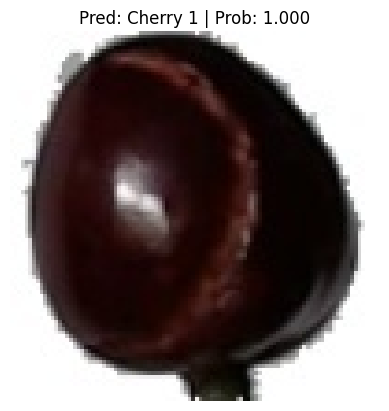

In [52]:
pred_and_plot_image(model=model,
                    image_path="data/Test/Cherry 1/3_100.jpg",
                    class_names=class_names,
                    image_size=(100,100),
                    device=device)